In [34]:
import rasterio as rio
import earthpy.spatial as es
import os, sys
from glob import glob
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import rasterio
from sklearn.cluster import KMeans

In [35]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

In [36]:
def histogram_stretch(img, min_vals = None, max_vals = 99):
    """
    Performs a histogram_stretch on an image. DO NOT use this for analytical workflows - 
    this should only be used to improve image visualization
    
    img: an unmasked 3D raster 
    
    min_vals: percentile that you wish to crop to
        will be np.zeros by default
    max_vals: percentile that you wish to crop to
        will be np.nanpercentile(img, 99) by default # crops to 99th percentile
    """
    if img.ndim != 3:
        print("ValueError: Your raster must have three dimensions.")
        return
    
    # This returns the max_valth percentile
    max_vals = np.nanpercentile(img, max_vals, axis = (1,2)).reshape(img.shape[0],1,1) 
    # min_vals = np.nanmin(tcc_toa, axis = (1,2)).reshape(3,1,1) # Use this to stretch to minimum values
    if min_vals is not None:
        min_vals = np.nanpercentile(img, min_vals, axis = (1,2)).reshape(img.shape[0],1,1)
    else:
        min_vals = np.zeros(img.shape[0]).reshape(img.shape[0],1,1)
    
    # Perform normalization
    img_stretched = (img - min_vals) / (max_vals - min_vals)
    
    # Clip values above 1
    img_stretched[img_stretched > 1] = 1
    
    return img_stretched

In [37]:
# Find all sub folders 1 level down from parent_dir
parent_dir = 'Raster_data'
sub_dirs = [x[0] for x in os.walk(parent_dir)]
sub_dirs = sub_dirs[1:]
sub_dirs = [x for x in sub_dirs if os.path.basename(os.path.dirname(x)) == parent_dir]
sub_dirs = [x for x in sub_dirs if "LC08_L2SP" in os.path.basename(x)]

stacked_filepaths = []

for sub_dir in sub_dirs:
    stacked_filename = "Nagasaki_CROPPED_STACKED.tif"
    stacked_filepath = os.path.join(sub_dir, stacked_filename)
    if os.path.exists(stacked_filepath):
        stacked_filepaths.append(stacked_filepath)

print(stacked_filepaths)

['Raster_data\\LC08_L2SP_113037_20130927_20200912_02_T1\\Nagasaki_CROPPED_STACKED.tif', 'Raster_data\\LC08_L2SP_113037_20140423_20200911_02_T1\\Nagasaki_CROPPED_STACKED.tif', 'Raster_data\\LC08_L2SP_113037_20151104_20200908_02_T1\\Nagasaki_CROPPED_STACKED.tif', 'Raster_data\\LC08_L2SP_113037_20160530_20200906_02_T1\\Nagasaki_CROPPED_STACKED.tif', 'Raster_data\\LC08_L2SP_113037_20170618_20200903_02_T1\\Nagasaki_CROPPED_STACKED.tif']


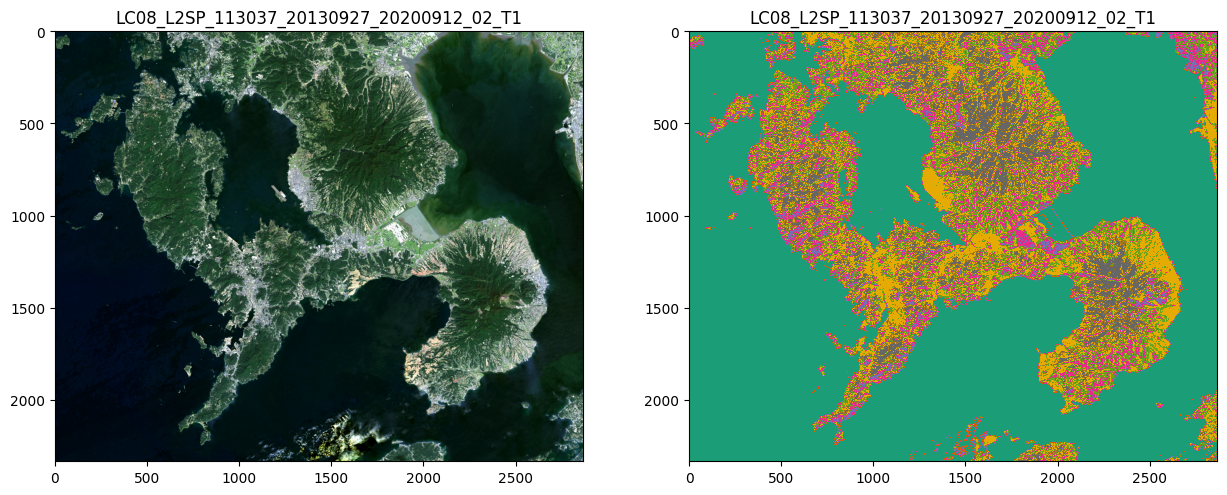

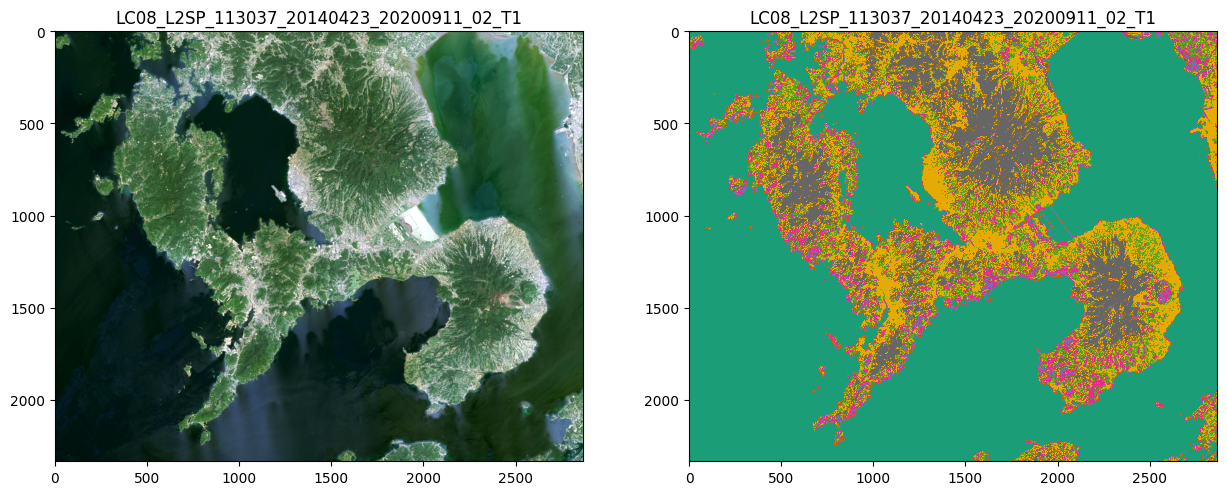

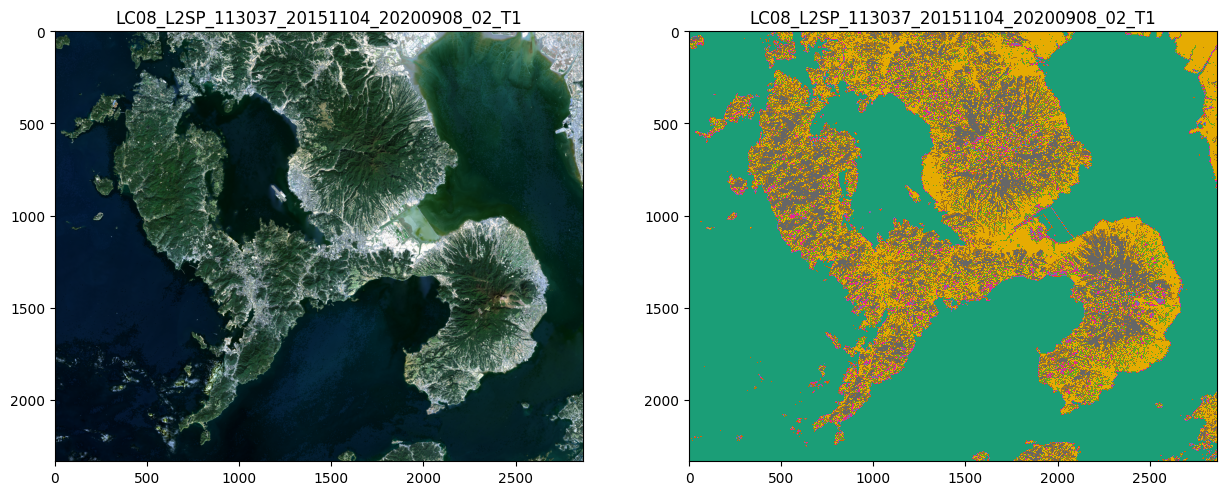

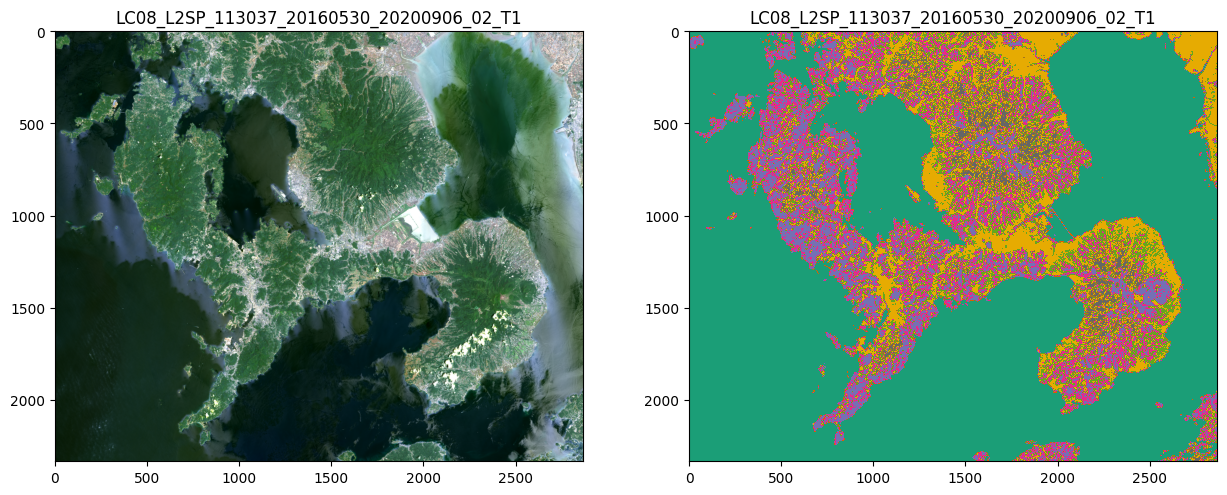

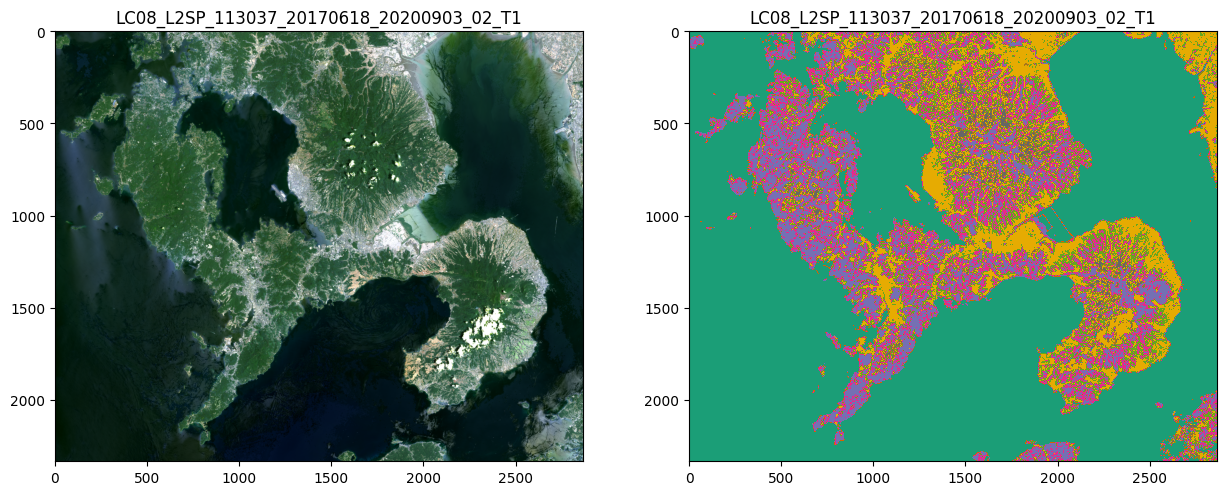

In [38]:
for i, filepath in enumerate(stacked_filepaths):
    with rio.open(filepath) as src:
        arr = src.read()
        band_num = src.count
        
    arr_processed = [np.clip(arr_band, np.percentile(arr_band,1), np.percentile(arr_band,99)) for arr_band in arr]
    arr_swapped = np.swapaxes(arr_processed, 0, 2)
    arr_swapped = np.swapaxes(arr_swapped, 0, 1)
    arr_reshaped = arr_swapped.reshape(-1, band_num)
    X = arr_reshaped.copy()
    
    if i == 0:
        # Train the model
        n_clusters = 4
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)
    labels = kmeans.predict(X).reshape(arr.shape[1], arr.shape[2])
    
    # Plot the original image side by side with the classmap
    fig, axs = plt.subplots(1,2,figsize=(15,8))
    

    # img_stretched = color_stretch(arr.reshape(-1, 8), [3, 2, 1])
    arr_scaled = arr * 0.0000275 - 0.2
    stretched_img = histogram_stretch(arr_scaled[[3,2,1],...])
    clipped_img = np.clip(stretched_img, 0, 1)
    show(clipped_img, ax=axs[0], title="Original Image")
    
    # Make the labels over the original image
    axs[1].imshow(labels, cmap="Dark2")
    # Use filepath as title
    axs[0].set_title(os.path.basename(os.path.dirname(filepath)))
    axs[1].set_title(os.path.basename(os.path.dirname(filepath)))
    # Show legend of each class
    # plt.colorbar(ticks=np.unique(labels))
    plt.show()
    

In [39]:
# input_filepath_2 = os.path.join("Raster_data", "LC08_L1TP_113037_20230502_20230509_02_T1", "Nagasaki_CROPPED_STACKED.tif")

input_filepath_2 = os.path.join("Raster_data", "LC08_L2SP_113037_20130927_20200912_02_T1", "Nagasaki_CROPPED_STACKED.tif")

with rio.open(input_filepath_2) as src:
    print(src.bounds)
    print(src.count)
    print(src.shape)
    
    # Get the array from the raster
    arr = src.read()
    band_num = src.count
    print(arr.shape)

BoundingBox(left=548985.0, bottom=3598995.0, right=635025.0, top=3669015.0)
8
(2334, 2868)
(8, 2334, 2868)


In [40]:
arr_processed = [np.clip(arr_band, np.percentile(arr_band,1), np.percentile(arr_band,99)) for arr_band in arr]

In [41]:
arr_swapped = np.swapaxes(arr_processed, 0, 2)
arr_swapped = np.swapaxes(arr_swapped, 0, 1)
print(arr_swapped.shape)
arr_reshaped = arr_swapped.reshape(-1, band_num)
X = arr_reshaped.copy()

(2334, 2868, 8)


In [42]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)

In [43]:
# Reshape the labels back to the original image dimensions
labels = kmeans.predict(X).reshape(arr.shape[1], arr.shape[2])

<Axes: title={'center': 'Original Image'}>

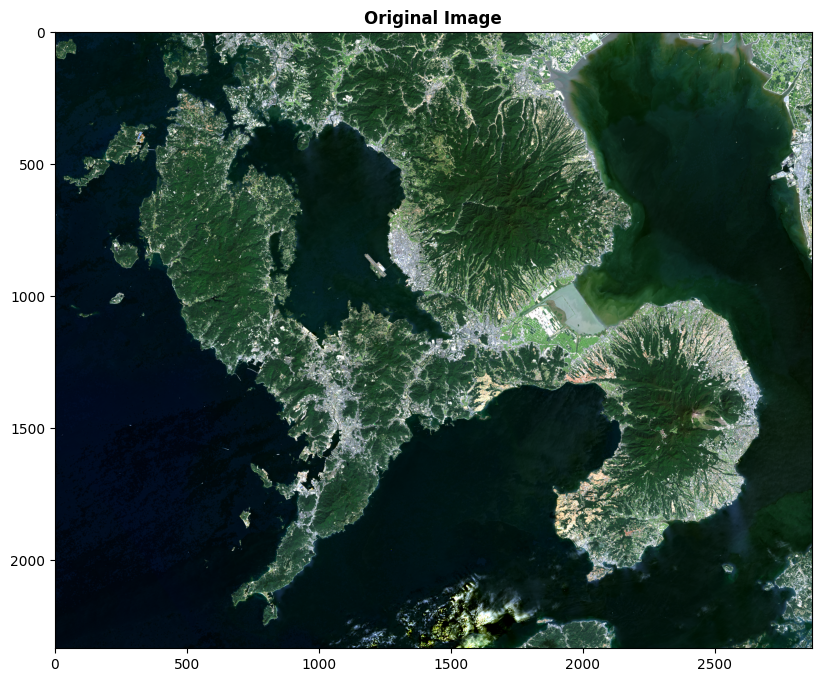

In [44]:
from rasterio.plot import show

# Now show the classmap next to the image
fig, axs = plt.subplots(1,1,figsize=(15,8))

# img_stretched = color_stretch(arr.reshape(-1, 8), [3, 2, 1])
arr_scaled = arr * 0.0000275 - 0.2
stretched_img = histogram_stretch(arr_scaled[[3,2,1],...])
clipped_img = np.clip(stretched_img, 0, 1)
show(clipped_img, ax=axs, title="Original Image")


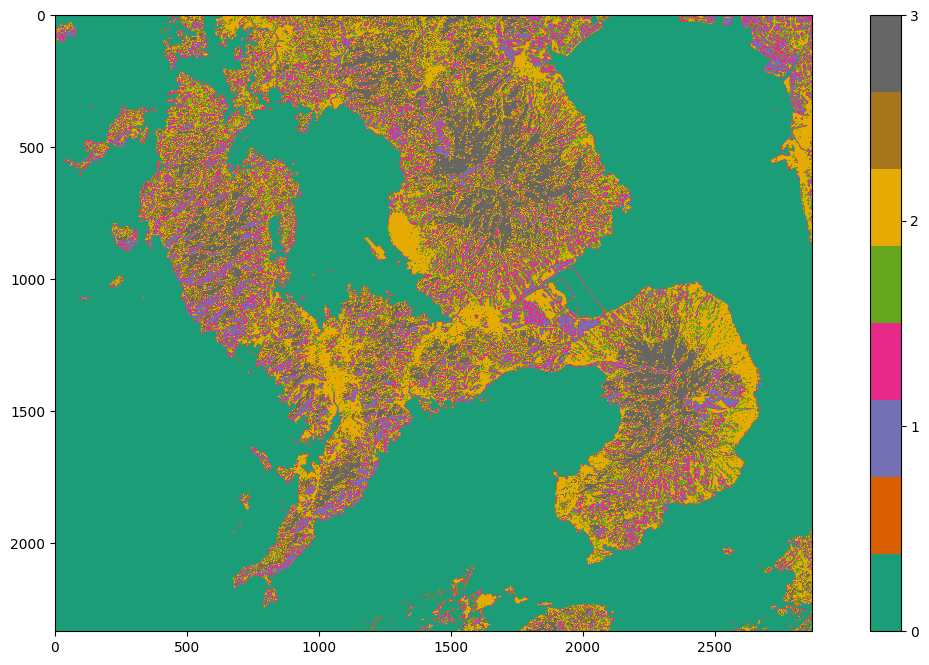

In [45]:
# Make the labels over the original image
fig, axs = plt.subplots(1,1,figsize=(15,8))
plt.imshow(labels, cmap="Dark2")
# Show legend of each class
plt.colorbar(ticks=np.unique(labels))
plt.show()

In [46]:
for i in range(n_clusters):
    print("Cluster", i)
    print(np.unique(labels[labels == i], return_counts=True))
    print("------")

Cluster 0
(array([0]), array([4050506], dtype=int64))
------
Cluster 1
(array([1]), array([1011460], dtype=int64))
------
Cluster 2
(array([2]), array([725036], dtype=int64))
------
Cluster 3
(array([3]), array([906910], dtype=int64))
------


[0.60510297 0.15110148 0.10831275 0.13548281]


Text(0.5, 1.0, 'Proportion of pixels in each class')

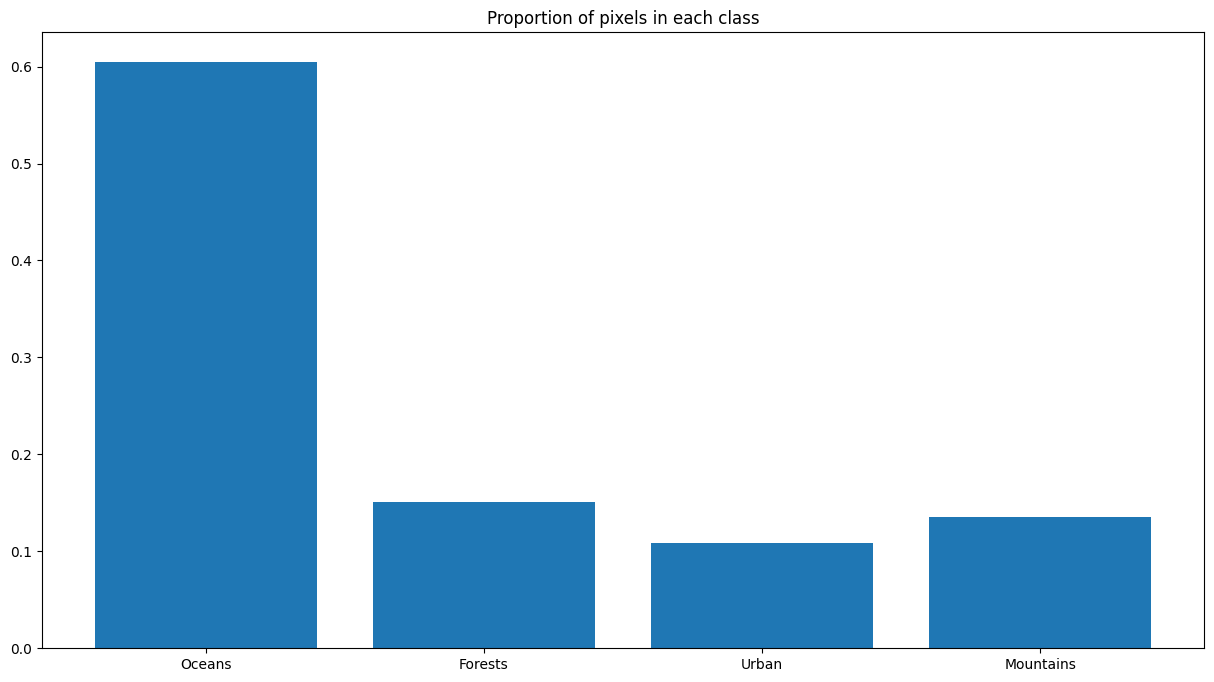

In [47]:
# Plot a bar chart of the proportion of pixels in each class
fig, axs = plt.subplots(1,1,figsize=(15,8))

legend = ["Oceans", "Forests", "Urban", "Mountains"]

proportion = np.unique(labels, return_counts=True)[1] / labels.size
print(proportion)
plt.bar(legend, proportion)
plt.title("Proportion of pixels in each class")